### Build a Recommender System


#### Reference
https://www.youtube.com/watch?v=SD3irxdKfxk&t=1117s

In [154]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as t
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


In [117]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
# Setting random seed value 

t.random.set_seed(42)

### Reading the datasets

In [119]:
# Reading the u.item dataset from google drive location

movie_dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/u.item", sep='|', names=["movie_id", "movie_title", "release_date", "video_release_date", "IMDB_URL", "unknown", "action", "adventure", "animation", "children", "comedy", "crime", "documentary", "drama", "fantasy", "film_noir", "horror", "musical", "mystery", "romance", "sci_fi", "thriller", "war", "western"], encoding = "cp1252")



In [120]:
movie_dataset.shape

(1682, 24)

In [121]:
movie_dataset.head(10)

,movie_id,movie_title,release_date,video_release_date,IMDB_URL,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [122]:
# Reading the u.data dataset from google drive location

rating_dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/u.data", sep='\t', names=["user_id", "movie_id", "rating", "timestamp"])

In [123]:
rating_dataset.shape

(100000, 4)

In [124]:
rating_dataset.head(10)

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [125]:
# Assigning a unique number starting from 0 to each user and do the same for each movie in the 'rating dataset' 

rating_dataset["user_id"] = rating_dataset["user_id"].astype('category').cat.codes.values
rating_dataset["movie_id"] = rating_dataset["movie_id"].astype('category').cat.codes.values

rating_dataset.head(10)

,user_id,movie_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596
5,297,473,4,884182806
6,114,264,2,881171488
7,252,464,5,891628467
8,304,450,3,886324817
9,5,85,3,883603013


In [126]:
print(movie_dim)

1682


In [127]:
print(user_dim)

943


In [128]:
# Assigning a unique number starting from 0 to  each movie in the 'movie dataset' 

movie_dataset["movie_id"] = movie_dataset["movie_id"].astype('category').cat.codes.values
movie_dataset.head(10)

,movie_id,movie_title,release_date,video_release_date,IMDB_URL,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
5,5,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,6,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7,7,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
8,8,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,9,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


## Creating the Train Test Split

In [196]:
X_train, X_test = train_test_split(rating_dataset, test_size=0.2, random_state=42)


In [197]:
print(f"Shape of train data: {X_train.shape}")
print(f"Shape of test data: {X_test.shape}")

Shape of train data: (80000, 4)
Shape of test data: (20000, 4)


In [198]:
# Checking unique number of users and movies

movie_dim = rating_dataset.movie_id.nunique()
user_dim = rating_dataset.user_id.nunique()

In [199]:
print(movie_dim)

1682


In [200]:
print(user_dim)

943


### Creating the Neural Network

In [201]:
#Movie Embedding Layer
input_movie_layer = tf.layers.Input(shape=[1])
embed_movie_layer = tf.layers.Embedding(movie_dim + 1,64, name="movie_embeddings")(input_movie_layer)
# This is the latent space for movies
movie_output = tf.layers.Flatten()(embed_movie_layer)


#User Embedding Layer
input_users_layer = tf.layers.Input(shape=[1])
embed_users_layer = tf.layers.Embedding(user_dim + 1,64, name="user_embeddings")(input_users_layer)
# This is the latest space for users
users_output = tf.layers.Flatten()(embed_users_layer)


# Concatenate Features
concat = tf.layers.Concatenate()([movie_output, users_output])

# Fully-Connected-Layers
dropout_0 = tf.layers.Dropout(0.2,name='Dropout0')(concat)
dense1 = tf.layers.Dense(128, activation='relu')(dropout_0)
dropout_1 = tf.layers.Dropout(0.2,name='Dropout1')(dense1)
batch_norm1 = BatchNormalization()(dropout_1)
dense2 = tf.layers.Dense(64, activation='relu')(batch_norm1)
dropout_2 = tf.layers.Dropout(0.2,name='Dropout2')(dense2)
batch_norm2 = BatchNormalization()(dropout_2)
dense3 = tf.layers.Dense(32, activation='relu')(batch_norm2)
dropout_3 = tf.layers.Dropout(0.2,name='Dropout3')(dense3)
batch_norm3 = BatchNormalization()(dropout_3)
dense4 = tf.layers.Dense(16, activation='relu')(batch_norm3)
dropout_4 = tf.layers.Dropout(0.2,name='Dropout4')(dense4)
batch_norm4 = BatchNormalization()(dropout_4)


# Output Layer

output = tf.layers.Dense(1)(batch_norm4)

In [202]:
# Create model
model = tf.Model([input_movie_layer, input_users_layer], output)

In [203]:
# Compile model (Using Root Mean Squarred Error for metrics as mentioned in the assignment) 

model.compile('adam', loss = MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [204]:
callbacks = [EarlyStopping(monitor="val_loss", patience=2),ModelCheckpoint(filepath="best.model.h1",monitor="val_loss", save_best_only=True)]

In [205]:
# Model Summary

model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embeddings (Embedding)    (None, 1, 64)        107712      input_17[0][0]                   
__________________________________________________________________________________________________
user_embeddings (Embedding)     (None, 1, 64)        60416       input_18[0][0]                   
____________________________________________________________________________________________

In [206]:
# Training the model

history = model.fit([X_train.movie_id, X_train.user_id], X_train.rating, callbacks=callbacks, validation_data=([X_test.movie_id, X_test.user_id], X_test.rating),
               batch_size=128, 
               epochs=10, 
               verbose=1)

Epoch 1/10
625/625 [==============================] - 5s 6ms/step - loss: 5.3111 - root_mean_squared_error: 2.3046 - val_loss: 1.2114 - val_root_mean_squared_error: 1.1006
INFO:tensorflow:Assets written to: best.model.h1/assets
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 1.4427 - root_mean_squared_error: 1.2011 - val_loss: 1.0598 - val_root_mean_squared_error: 1.0295
INFO:tensorflow:Assets written to: best.model.h1/assets
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 1.1119 - root_mean_squared_error: 1.0545 - val_loss: 0.9259 - val_root_mean_squared_error: 0.9622
INFO:tensorflow:Assets written to: best.model.h1/assets
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.9750 - root_mean_squared_error: 0.9874 - val_loss: 0.8980 - val_root_mean_squared_error: 0.9476
INFO:tensorflow:Assets written to: best.model.h1/assets
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.9274 - root_

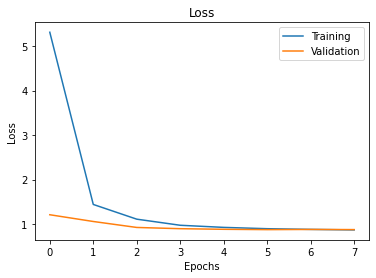

In [207]:
#Visualizing the Loss

epoch_range = range(0,8)
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

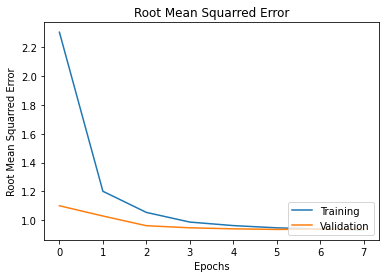

In [208]:
# Visualizing  Metrics - Root Mean Squarred Error 

epoch_range = range(0,8)
plt.plot(epoch_range, history.history['root_mean_squared_error'])
plt.plot(epoch_range, history.history['val_root_mean_squared_error'])
plt.title('Root Mean Squarred Error')
plt.ylabel('Root Mean Squarred Error')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Prediction

In [209]:
# Making prediction for first 10 user/movie combination in test dataset

predictions = model.predict([X_test.movie_id.head(10), X_test.user_id.head(10)])
[print(predictions[i], X_test.rating.iloc[i]) for i in range(0,9)]

[3.8298414] 4
[3.7500157] 3
[3.9275358] 4
[3.1725402] 2
[3.8768182] 2
[3.2298408] 3
[3.6593592] 5
[4.0045657] 4
[3.2515357] 3


[None, None, None, None, None, None, None, None, None]

In [212]:
# Formulating the dataset for making recommendations  for the 100th user 

movie_data = np.array(movie_id)
user = np.array([99 for i in range(len(movie_id))])
predictions = model.predict([movie_data, user])
predictions

array([[3.9147003],
       [3.9892569],
       [2.3895485],
       ...,
       [3.2133615],
       [3.2170358],
       [3.281413 ]], dtype=float32)

In [213]:
# 10 best recommended movies for user 100th

predictions = np.array([a[0] for a in predictions])
recommended_movie_ids = (-predictions).argsort()[:10]
print(recommended_movie_ids)
print(predictions[recommended_movie_ids])

[ 239  180  200  277  819  174   78  612   36 1239]
[4.263422  4.261003  4.2552867 4.2215247 4.2112737 4.2015376 4.1999006
 4.1891265 4.1788964 4.1767316]


In [214]:
# Display the recommendation for User 100th

movie_dataset.movie_title.iloc[recommended_movie_ids]

239         Beavis and Butt-head Do America (1996)
180                      Return of the Jedi (1983)
200                            Evil Dead II (1987)
277                            Bed of Roses (1996)
819                               Space Jam (1996)
174                                  Brazil (1985)
78                            Fugitive, The (1993)
612                          My Man Godfrey (1936)
36                                    Nadja (1994)
1239    Ghost in the Shell (Kokaku kidotai) (1995)
Name: movie_title, dtype: object

## Summary

In this project, we simulate a movie recommendation system leveraging neural networks. It is based on the principles of matrix factorization. Through backpropagation, we predict the values in the latent space.

The dataset u.item contains the features and details about the movies. The dataset u.data contains the user id , movie id and the corresponding rating for the movies. We first find out the unique number of users and movies to find the matrix dimension. The ids in both the dataset are adjusted to have unique values starting from 0. The dataset u.data is then split into training and test split. 

Neural Network -

Both User and movies data are embeded with a dimenion of [ no of user, 64 ] and [number of movies, 64]. The latent dimension of 64 was narrowed down upon multiple experiment (ranging from 25-150).
The latent user and movies vectors are then concatenated and fed into the network.
The network comprises of 4 layers (Dense, Droput and Batch Normalisation) and an output layer of one unit.
The neural network structure is 128->64->32->16 units
The training and validation loss converged at around 10 epochs.

Experimented with various depth of neural network and units but the validation loss did not go below 0.8.
Root Mean Squareed was used as metrics for compiling the model (as mentioned in the assignment). 

Prediction -

Prediction was made for the first 10 user/movie combination. Then we visualized 10 recommended movies for user #100 in the list